In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

plt.rcParams['figure.figsize'] = 15, 10

## Load SIFT dataset

In [2]:
def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='int32', mode='r')
    d = x[0]
    return x.view('float32').reshape(-1, d + 1)[:, 1:]

def mmap_bvecs(fname):
    x = np.memmap(fname, dtype='uint8', mode='r')
    d = x[:4].view('int32')[0]
    return x.reshape(-1, d + 4)[:, 4:]

def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    # Wenqi: Format of ground truth (for 10000 query vectors):
    #   1000(topK), [1000 ids]
    #   1000(topK), [1000 ids]
    #        ...     ...
    #   1000(topK), [1000 ids]
    # 10000 rows in total, 10000 * 1001 elements, 10000 * 1001 * 4 bytes
    return a.reshape(-1, d + 1)[:, 1:].copy()

def fvecs_read(fname):
    return ivecs_read(fname).view('float32')

In [3]:
dbname = 'SIFT1M'

if dbname.startswith('SIFT'):
    # SIFT1M to SIFT1000M
    dbsize = int(dbname[4:-1])
    xb = mmap_bvecs('/mnt/scratch/wenqi/Faiss_experiments/bigann/bigann_base.bvecs')
    xq = mmap_bvecs('/mnt/scratch/wenqi/Faiss_experiments/bigann/bigann_query.bvecs')
    gt = ivecs_read('/mnt/scratch/wenqi/Faiss_experiments/bigann/gnd/idx_%dM.ivecs' % dbsize)

    N_VEC = int(dbsize * 1000 * 1000)

    # trim xb to correct size
    xb = xb[:dbsize * 1000 * 1000]

    # Wenqi: load xq to main memory and reshape
    xq = xq.astype('float32').copy()
#     xq = np.array(xq, dtype=np.float32)
    xb = xb.astype('float32').copy()
    gt = np.array(gt, dtype=np.int32)

    print("Vector shapes:")
    print("Base vector xb: ", xb.shape)
    print("Query vector xq: ", xq.shape)
    print("Ground truth gt: ", gt.shape)
else:
    print('unknown dataset', dbname, file=sys.stderr)
    sys.exit(1)

dim = xb.shape[1] # should be 128
nq = xq.shape[0]

# Normalize all to 0~1
xb = xb / 256
xq = xq / 256

Vector shapes:
Base vector xb:  (1000000, 128)
Query vector xq:  (10000, 128)
Ground truth gt:  (10000, 1000)


In [4]:
# Using the first 10K vectors for training, just as the graph & IVF experiments
n_train = int(1e4)
xt = xb[:n_train]
print(xt.shape)

(10000, 128)


In [5]:
xb[0]

array([0.        , 0.        , 0.        , 0.00390625, 0.03125   ,
       0.02734375, 0.01171875, 0.0078125 , 0.01953125, 0.        ,
       0.        , 0.01171875, 0.01953125, 0.02734375, 0.04296875,
       0.12109375, 0.05078125, 0.        , 0.        , 0.        ,
       0.        , 0.11328125, 0.4140625 , 0.41796875, 0.05078125,
       0.        , 0.        , 0.        , 0.00390625, 0.23828125,
       0.2734375 , 0.1640625 , 0.        , 0.        , 0.        ,
       0.        , 0.00390625, 0.08984375, 0.109375  , 0.0625    ,
       0.24609375, 0.015625  , 0.        , 0.        , 0.        ,
       0.0234375 , 0.32421875, 0.31640625, 0.45703125, 0.3359375 ,
       0.09765625, 0.05859375, 0.06640625, 0.1953125 , 0.328125  ,
       0.45703125, 0.12109375, 0.08984375, 0.0703125 , 0.13671875,
       0.37890625, 0.45703125, 0.19140625, 0.09375   , 0.265625  ,
       0.10546875, 0.        , 0.        , 0.        , 0.015625  ,
       0.11328125, 0.27734375, 0.31640625, 0.18359375, 0.05078

## Model Declaration

Maybe I need to get rid of the sigmoid function, because there are a lot of 0s and 255s, and using sigmoid to get those values are very hard

In [29]:
# Creating a DeepAutoencoder class

# We partition the data to 32 shards (bottleneck dimension)
# The input data is 128-dimension
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
#             torch.nn.Sigmoid()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
# loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [30]:
# def loss_func(reconstructed_feat, input_feat, hidden_feat, centroid_vectors, partition_ids):
#     """
    
#     """
#     full_dim = reconstructed_feat.shape[1]
#     hidden_dim = hidden_feat.shape[1]
#     hidden_feat_factor = full_dim / hidden_dim
    
#     batch_size = reconstructed_feat.shape[0]
# #     assert batch_size == input_feat.shape[0] and batch_size == hidden_feat.shape[0] and \
# #         batch_size == partition_ids.shape[0]]
# #     assert hidden_dim == centroid_vectors.shape[1]

#     min_square_error = (reconstructed_feat - input_feat)**2
#     cluster_error = 0
#     for i in range(hidden_feat.shape[0]):
#         cluster_error += torch.sum((hidden_feat[i] - centroid_vectors[partition_ids[i]]) ** 2)
#     ave_cluster_error = hidden_feat_factor * cluster_error / batch_size / hidden_dim
#     loss = torch.mean(min_square_error) + ave_cluster_error
    
#     return loss

In [31]:
def loss_func(reconstructed_feat, input_feat, hidden_feat, centroid_vectors, partition_id_list):
    """
    centroid vectors: same shape as hidden_feat
    """
    
    full_dim = reconstructed_feat.shape[1]
    hidden_dim = hidden_feat.shape[1]
    hidden_feat_factor = full_dim / hidden_dim
    
    min_square_error = (reconstructed_feat - input_feat)**2
    
    cluster_error = 0
    for i in range(hidden_feat.shape[0]):
        cluster_error += torch.sum((hidden_feat[i] - centroid_vectors[partition_id_list[i]]) ** 2)
        
    ave_cluster_error = hidden_feat_factor * cluster_error / batch_size / hidden_dim
    loss = torch.mean(min_square_error) + ave_cluster_error
    
    return loss

In [32]:
model.parameters

<bound method Module.parameters of DeepAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Sigmoid()
  )
)>

## Train the model

Model 1: no sigmoid in the middle, with sigmoid in the end; 3 layers
Init loss (sigmoid) = 0.06 (given batch size = 100, ~600)
loss after 100 epoch = 0.005 (~10% init)
loss after 1100 epoch = 0.00236 (~4% init)

Model 2: no sigmoid in the middle, no sigmoid in the end; 4 layers
Init loss = 492
loss after 100 epoch = 221 (~50% init)
loss after 600 epoch = 161
loss after 1100 epoch = 153 (switching batch size to 1000): 

Model 3: no sigmoid in the middle, with sigmoid in the end; 4 layers
Init loss (sigmoid) = 8
loss after 100 epoch = 0.500 (~10% init)
loss after 1100 epoch = 0.260 (~3% init)

Model 3: with sigmoid in the middle, with sigmoid in the end; 4 layers
Init loss (sigmoid) = 5.4
loss after 100 epoch = 0.57 (~10% init)
loss after 1000 epoch = 0.29 (~3% init)


Model 3: no sigmoid in the middle, no sigmoid in the end; 5 layers
Init loss (sigmoid) = 1.0
loss after 100 epoch = xx (~10% init)
loss after 1000 epoch = xx (~3% init)

In [33]:
def get_centroid_vectors(hidden_feature, partition_id_list):
    """
    Input: 
      - hidden_feature (torch tensor): (num_vectors, num_partitions)
      - ID list (array): size = vector number; vec ID -> partition ID
    
    Output (updated):
      - centroids info (torch tensor): (num_partitions, num_partitions) 
          first dim: different centroid IDs
          second dim: an entire centroid vector
    """
    num_vectors = len(partition_id_list)
    num_partition = hidden_feature.shape[1]
    
    num_vectors_per_partition = np.zeros(num_partition)
    new_centroid_vectors_sum = torch.zeros(num_partitions, num_partitions) 
    for vec_id in range(num_vectors):
        partition_ID = partition_id_list[vec_id]
        num_vectors_per_partition[partition_ID] += 1
        new_centroid_vectors_sum[partition_ID] += hidden_feature[vec_id]
        
    new_centroid_vectors = torch.zeros(num_partitions, num_partitions) 
    for partition_id in range(num_partition):
        new_centroid_vectors[partition_id] = \
            new_centroid_vectors_sum[partition_id] / num_vectors_per_partition[partition_id] 
    
    return new_centroid_vectors

def update_centroids_info(hidden_feature, partition_id_list, centroid_vectors):
    """
    Input: 
      - hidden_feature (torch tensor): (num_vectors, num_partitions)
      - ID list (array): size = vector number; vec ID -> partition ID
      - centroids info (torch tensor): (num_partitions, num_partitions) 
          first dim: different centroid IDs
          second dim: an entire centroid vector
    
    Output (updated):
      - ID list (array): vec ID -> partition ID
      - centroids info (torch tensor): (num_partitions, num_partitions) 
          first dim: different centroid IDs
          second dim: an entire centroid vector
    """
    
    num_vectors = len(partition_id_list)
    num_partition = centroid_vectors.shape[0]
    
    num_vectors_per_partition = np.zeros(num_partition)
    new_centroid_vectors_sum = torch.zeros(num_partitions, num_partitions) 
    for vec_id in range(num_vectors):
        partition_ID = partition_id_list[vec_id]
        num_vectors_per_partition[partition_ID] += 1
        new_centroid_vectors_sum[partition_ID] += hidden_feature[vec_id]
        
    new_centroid_vectors = torch.zeros(num_partitions, num_partitions) 
    for partition_id in range(num_partition):
        new_centroid_vectors[partition_id] = \
            new_centroid_vectors_sum[partition_id] / num_vectors_per_partition[partition_id]
        
    new_L2_dist = torch.zeros((num_partition, num_vectors))
    for paritition_id in range(num_partition):
        # L2 distance to the i th centroid, output size = num_vec
        new_L2_dist[paritition_id] = torch.sum((hidden_feature - centroid_vectors[paritition_id]) ** 2, dim=1)
    new_partition_id_list = torch.argmin(new_L2_dist, dim = 0)
    
    return new_partition_id_list, new_centroid_vectors

In [34]:
num_epochs = 1000 # Wenqi: original iteration = 100
batch_size = 100
num_train_vectors = int(1e4)
num_partitions = 32

# List that will store the training loss
train_loss = []
validation_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}
x_val = torch.FloatTensor(xb[num_train_vectors: 2 * num_train_vectors])
xt_tensor = torch.FloatTensor(xt)

hidden_feature = model.encoder(xt_tensor)
# Initiation: each vector starts with a random partition ID; 
#   each partition has a center vector
xt_closest_partition_id = np.random.randint(0, high=num_partitions, size=num_train_vectors)
centroid_vectors = get_centroid_vectors(hidden_feature, xt_closest_partition_id)

print('partition ID list', xt_closest_partition_id)
print('centroid vectors', centroid_vectors)

partition ID list [19 30  9 ... 31 12  0]
centroid vectors tensor([[ 0.0381,  0.0966, -0.0289,  ...,  0.0128,  0.0071, -0.0853],
        [ 0.0386,  0.0976, -0.0284,  ...,  0.0128,  0.0073, -0.0852],
        [ 0.0381,  0.0966, -0.0287,  ...,  0.0126,  0.0069, -0.0854],
        ...,
        [ 0.0381,  0.0964, -0.0283,  ...,  0.0137,  0.0066, -0.0852],
        [ 0.0382,  0.0965, -0.0287,  ...,  0.0126,  0.0067, -0.0853],
        [ 0.0387,  0.0962, -0.0295,  ...,  0.0131,  0.0061, -0.0847]],
       grad_fn=<CopySlices>)


In [35]:
centroid_vectors

tensor([[ 0.0381,  0.0966, -0.0289,  ...,  0.0128,  0.0071, -0.0853],
        [ 0.0386,  0.0976, -0.0284,  ...,  0.0128,  0.0073, -0.0852],
        [ 0.0381,  0.0966, -0.0287,  ...,  0.0126,  0.0069, -0.0854],
        ...,
        [ 0.0381,  0.0964, -0.0283,  ...,  0.0137,  0.0066, -0.0852],
        [ 0.0382,  0.0965, -0.0287,  ...,  0.0126,  0.0067, -0.0853],
        [ 0.0387,  0.0962, -0.0295,  ...,  0.0131,  0.0061, -0.0847]],
       grad_fn=<CopySlices>)

In [36]:
xt_closest_partition_id, centroid_vectors = update_centroids_info(hidden_feature, xt_closest_partition_id, centroid_vectors)
print('partition ID list', xt_closest_partition_id)
print('centroid vectors', centroid_vectors)

partition ID list tensor([19, 16, 11,  ...,  2, 28, 10])
centroid vectors tensor([[ 0.0381,  0.0966, -0.0289,  ...,  0.0128,  0.0071, -0.0853],
        [ 0.0386,  0.0976, -0.0284,  ...,  0.0128,  0.0073, -0.0852],
        [ 0.0381,  0.0966, -0.0287,  ...,  0.0126,  0.0069, -0.0854],
        ...,
        [ 0.0381,  0.0964, -0.0283,  ...,  0.0137,  0.0066, -0.0852],
        [ 0.0382,  0.0965, -0.0287,  ...,  0.0126,  0.0067, -0.0853],
        [ 0.0387,  0.0962, -0.0295,  ...,  0.0131,  0.0061, -0.0847]],
       grad_fn=<CopySlices>)


In [37]:
sift_in_batch = xt_tensor[0 * batch_size: (0 + 1) * batch_size]
print((sift_in_batch ** 2).shape)
print(torch.mean(sift_in_batch), torch.mean(sift_in_batch).shape)

torch.Size([100, 128])
tensor(0.1074) torch.Size([])


out_batch torch.Size([10000, 128]) tensor([[0.5130, 0.4774, 0.4915,  ..., 0.4823, 0.5457, 0.4795],
        [0.5133, 0.4775, 0.4920,  ..., 0.4825, 0.5455, 0.4796],
        [0.5130, 0.4772, 0.4914,  ..., 0.4824, 0.5460, 0.4791],
        ...,
        [0.5130, 0.4776, 0.4917,  ..., 0.4825, 0.5455, 0.4799],
        [0.5128, 0.4776, 0.4916,  ..., 0.4823, 0.5454, 0.4801],
        [0.5128, 0.4771, 0.4913,  ..., 0.4822, 0.5461, 0.4790]],
       grad_fn=<SigmoidBackward>)
sift_in_batch torch.Size([10000, 128]) tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0391, 0.0234],
        [0.2539, 0.1367, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
        ...,
        [0.0273, 0.0195, 0.0273,  ..., 0.1758, 0.0625, 0.0898],
        [0.1484, 0.0000, 0.0000,  ..., 0.1055, 0.0156, 0.0312],
        [0.0000, 0.0000, 0.0078,  ..., 0.1172, 0.0117, 0.0000]])
hidden_feature torch.Size([10000, 32]) tensor([[ 0.0534,  0.0953, -0.0180,  ..., -0.0033,  0.020

ValueError: x and y must have same first dimension, but have shapes (1000,) and (3,)

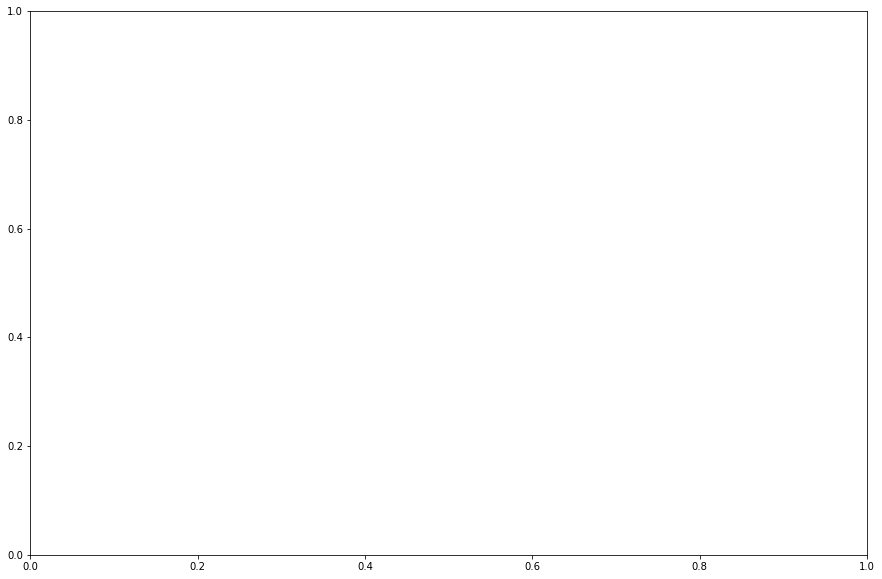

In [38]:
# Training loop starts ===》 WITHOUT BATCH LOOP ===> HUGE BATCH
xt_closest_partition_id = np.random.randint(0, 32, size=10000)
for epoch in range(num_epochs):

    # Initializing variable for storing
    # loss
    running_loss = 0
    
        
    # WENQI: NOTE That the input is mapped to 0~1 -> such that we use sigmod to get the output value
    sift_in_batch = xt_tensor
#         print('in', sift_in_batch.shape, sift_in_batch[0])

    # Generating output
    out_batch = model(sift_in_batch)
    hidden_feature = model.encoder(sift_in_batch)

    # Calculating loss
    print('out_batch', out_batch.shape, out_batch)
    print('sift_in_batch', sift_in_batch.shape, sift_in_batch)
    print('hidden_feature', hidden_feature.shape, hidden_feature)
    print('centroid_vectors', centroid_vectors.shape, centroid_vectors)
    print('xt_closest_partition_id', xt_closest_partition_id.shape, xt_closest_partition_id)
    loss = loss_func(out_batch, sift_in_batch, 
                     hidden_feature, centroid_vectors, 
                     xt_closest_partition_id)
    if torch.isnan(loss):
        print('NaN loss, break...')
        break
    # Updating weights according
    # to the calculated loss
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    # Incrementing loss
    running_loss += loss.item()
        
    train_loss.append(running_loss)
    
#     out_val = model(x_val)
#     out_hidden = 
#     loss_val = loss_func(out_val, x_val)
#     validation_loss.append(loss_val)
    
    print("epoch:", epoch, "train loss:", running_loss)
#     print("epoch:", epoch, "train loss:", running_loss, "val loss: ", loss_val.item())

    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'in': sift_in_batch, 'out': out_batch}
    
    # update centroids after an epoch
    xt_closest_partition_id, centroid_vectors = update_centroids_info(
        hidden_feature, xt_closest_partition_id, centroid_vectors)
    


# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
# plt.plot(range(1,num_epochs+1),validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

In [19]:
torch.isnan(loss)

tensor(True)

In [20]:
# Training loop starts
for epoch in range(num_epochs):

    # Initializing variable for storing
    # loss
    running_loss = 0
    
    # Iterating over the training dataset
    batch_num_per_epoch = int(np.ceil(n_train / batch_size))
#     print(batch_num_per_epoch)

    hidden_feature = model.encoder(xt_tensor)
    for i_batch in range(batch_num_per_epoch):

        start_id = i_batch * batch_size
        end_id = (i_batch + 1) * batch_size
        
        # WENQI: NOTE That the input is mapped to 0~1 -> such that we use sigmod to get the output value
        sift_in_batch = xt_tensor[start_id: end_id]
#         print('in', sift_in_batch.shape, sift_in_batch[0])

        # Generating output
        out_batch = model(sift_in_batch)
        hidden_feature_batch = model.encoder(sift_in_batch)
        hidden_feature[start_id: end_id] = hidden_feature_batch
#         print('out', out.shape, out[0])

        # Calculating loss
        xt_closest_partition_id_batch = xt_closest_partition_id[start_id: end_id]
        loss = loss_func(out_batch, sift_in_batch, 
                         hidden_feature_batch, centroid_vectors, 
                         xt_closest_partition_id_batch)

        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # Incrementing loss
        running_loss += loss.item()
        

    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
    
#     out_val = model(x_val)
#     out_hidden = 
#     loss_val = loss_func(out_val, x_val)
#     validation_loss.append(loss_val)
    
    print("epoch:", epoch, "train loss:", running_loss)
#     print("epoch:", epoch, "train loss:", running_loss, "val loss: ", loss_val.item())

    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'in': sift_in_batch, 'out': out}
    
    # update centroids after an epoch
    xt_closest_partition_id, centroid_vectors = update_centroids_info(
        hidden_feature, xt_closest_partition_id, centroid_vectors)
    


# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
# plt.plot(range(1,num_epochs+1),validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

epoch: 0 train loss: nan


NameError: name 'out' is not defined

In [129]:
# Inspecting the result of a single vector

i_batch = 0

# Loading image(s) and
# reshaping it into a 1-d vector
sift_in_batch = torch.FloatTensor(xt[i_batch * batch_size: (i_batch + 1) * batch_size])
print('in', sift_in_batch.shape, sift_in_batch[0])

# Generating output
out = model(sift_in_batch)
print('out', out.shape, out[0])
    
for i in range(128):
    print('in: ', sift_in_batch[0][i], 'out: ', out[0][i])

in torch.Size([100, 128]) tensor([0.0000, 0.0000, 0.0000, 0.0039, 0.0312, 0.0273, 0.0117, 0.0078, 0.0195,
        0.0000, 0.0000, 0.0117, 0.0195, 0.0273, 0.0430, 0.1211, 0.0508, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1133, 0.4141, 0.4180, 0.0508, 0.0000, 0.0000,
        0.0000, 0.0039, 0.2383, 0.2734, 0.1641, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0039, 0.0898, 0.1094, 0.0625, 0.2461, 0.0156, 0.0000, 0.0000, 0.0000,
        0.0234, 0.3242, 0.3164, 0.4570, 0.3359, 0.0977, 0.0586, 0.0664, 0.1953,
        0.3281, 0.4570, 0.1211, 0.0898, 0.0703, 0.1367, 0.3789, 0.4570, 0.1914,
        0.0938, 0.2656, 0.1055, 0.0000, 0.0000, 0.0000, 0.0156, 0.1133, 0.2773,
        0.3164, 0.1836, 0.0508, 0.0391, 0.1250, 0.3398, 0.4570, 0.4570, 0.1758,
        0.2969, 0.1562, 0.0859, 0.2344, 0.2734, 0.1602, 0.0352, 0.0273, 0.0820,
        0.1133, 0.1523, 0.2070, 0.0820, 0.0156, 0.0039, 0.2148, 0.2812, 0.0117,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0352, 0.2539, 0.4570, 0.2852, 0.1445,
        0.1094

In [130]:
# sift_in_batch / 256

## K means on hidden feature

In [141]:
from sklearn.cluster import KMeans

In [189]:
hidden_features_10K = model.encoder(torch.FloatTensor(xt)).detach().numpy()
print(hidden_features_10K.shape)
print(hidden_features_10K[0])

(10000, 32)
[ 0.19215745  1.2356458  -0.55529815 -0.580348   -0.70802015  0.38527507
  0.24764977  0.08810449  0.55208504  0.0084953  -0.43993902 -0.74304897
  1.139927   -1.0337955   0.5081504  -0.20082477  0.02990077 -0.07197974
 -0.14414987  0.1186108  -0.4632683   0.39389193 -0.57805717 -0.32012156
 -0.27312028  0.36488637  0.15000263  0.10088865  0.03375911  0.03263886
  0.27500322  0.6829792 ]


In [190]:
kmeans = KMeans(n_clusters=32)
kmeans.fit(hidden_features_10K)
y_kmeans = kmeans.predict(hidden_features_10K)

In [191]:
print(y_kmeans)

[13  1 13 ... 20 14 12]


In [192]:
hidden_feature_1M = model.encoder(torch.FloatTensor(xb)).detach().numpy()

partition_IDs = kmeans.predict(hidden_feature_1M)
print(partition_IDs)
print(partition_IDs.shape)

[13  1 13 ...  9  8 15]
(1000000,)


In [193]:
# Create a mapping: partition ID -> {list of vector IDs}

num_partition = 32

partition_id_vec_id_list_1M = dict()
for i in range(num_partition):
    partition_id_vec_id_list_1M[i] = []


for i in range(int(1e6)):
    partition_ID = int(partition_IDs[i])
    partition_id_vec_id_list_1M[partition_ID].append(i)
    
for i in range(num_partition):
    print('items in partition ', i, len(partition_id_vec_id_list_1M[i]), 'average =', int(1e6/num_partition))


items in partition  0 31246 average = 31250
items in partition  1 24537 average = 31250
items in partition  2 31969 average = 31250
items in partition  3 29831 average = 31250
items in partition  4 41228 average = 31250
items in partition  5 24541 average = 31250
items in partition  6 37040 average = 31250
items in partition  7 23075 average = 31250
items in partition  8 21908 average = 31250
items in partition  9 30168 average = 31250
items in partition  10 45163 average = 31250
items in partition  11 30958 average = 31250
items in partition  12 45456 average = 31250
items in partition  13 30161 average = 31250
items in partition  14 26478 average = 31250
items in partition  15 25687 average = 31250
items in partition  16 29251 average = 31250
items in partition  17 26623 average = 31250
items in partition  18 44392 average = 31250
items in partition  19 35272 average = 31250
items in partition  20 25693 average = 31250
items in partition  21 28595 average = 31250
items in partition  

In [194]:
import heapq

def scan_partition(query_vec, partition_id_list, vector_set):
    """
    query_vec = (128, )
    partition_id_list = (N_num_vec, )
    vector_set = 1M dataset (1M, 128)
    """
    min_dist = 1e10
    min_dist_ID = None
    for vec_id in partition_id_list:
        dataset_vec = vector_set[vec_id]
        dist = np.linalg.norm(query_vec - dataset_vec)
        if dist <= min_dist:
            min_dist = dist
            min_dist_ID = vec_id
            
    return min_dist_ID

In [195]:
nearest_neighbors = []

N = 1000
#### Wenqi: here had a bug: previously xb, now xq
query_hidden_feature = model.encoder(torch.FloatTensor(xq)).detach().numpy()
print(query_hidden_feature.shape)
query_partition = kmeans.predict(query_hidden_feature)

for i in range(N):
    partition_id = int(query_partition[i])
    nearest_neighbor_ID = scan_partition(xq[i], partition_id_vec_id_list_1M[partition_id], xb)
    nearest_neighbors.append(nearest_neighbor_ID)
    print(i, nearest_neighbor_ID)

(10000, 32)
0 504814
1 790327
2 552515
3 335355
4 189069
5 508403
6 342520
7 327960
8 834657
9 360082
10 878295
11 353408
12 215771
13 653682
14 368047
15 776345
16 373550
17 615740
18 602078
19 84644
20 68023
21 114330
22 756153
23 436181
24 698614
25 593360
26 922290
27 427711
28 495856
29 784549
30 429906
31 407192
32 295009
33 190504
34 554182
35 825435
36 428565
37 812777
38 341091
39 856200
40 982373
41 499763
42 915089
43 43368
44 77190
45 858815
46 436180
47 135525
48 28097
49 426503
50 629910
51 467756
52 803688
53 74183
54 819365
55 882827
56 535502
57 636955
58 111148
59 12747
60 534495
61 833563
62 611787
63 45494
64 943477
65 809566
66 3367
67 850184
68 570247
69 434096
70 116383
71 753756
72 222336
73 787309
74 436415
75 629700
76 470987
77 245786
78 680004
79 694111
80 23773
81 380662
82 26209
83 34810
84 632431
85 853398
86 299980
87 138747
88 698591
89 845760
90 32380
91 490742
92 190435
93 76908
94 657946
95 330662
96 898436
97 763985
98 532460
99 72670
100 614216
101

765 626998
766 286990
767 406153
768 873450
769 338094
770 850300
771 15926
772 577218
773 364685
774 13901
775 350272
776 195831
777 118452
778 291543
779 554970
780 210716
781 124102
782 162055
783 846066
784 930962
785 847884
786 75426
787 674141
788 333432
789 952892
790 615013
791 145455
792 582759
793 264499
794 712932
795 828717
796 740540
797 730877
798 334333
799 517289
800 251837
801 987659
802 353968
803 400426
804 139296
805 732260
806 453757
807 824656
808 283818
809 364339
810 970904
811 559136
812 190387
813 977042
814 52001
815 368665
816 520919
817 898180
818 817187
819 415637
820 589020
821 517952
822 528733
823 231175
824 44088
825 790393
826 822125
827 475844
828 977449
829 553157
830 363525
831 561089
832 927232
833 606764
834 264686
835 498594
836 796565
837 763906
838 458628
839 961898
840 634868
841 265298
842 322403
843 100085
844 852061
845 519099
846 863005
847 756718
848 684671
849 322370
850 863065
851 449281
852 489485
853 290520
854 755704
855 324754
856 

In [196]:
print(gt[:100, :1])

[[504814]
 [588616]
 [552515]
 [335355]
 [482427]
 [508403]
 [167240]
 [327960]
 [834657]
 [592948]
 [878295]
 [771023]
 [215771]
 [717949]
 [368047]
 [776345]
 [373550]
 [862239]
 [602078]
 [ 84644]
 [ 68023]
 [671173]
 [ 47363]
 [258880]
 [698614]
 [838692]
 [922290]
 [221028]
 [962851]
 [785288]
 [425493]
 [407192]
 [229032]
 [909787]
 [303455]
 [825435]
 [602485]
 [812777]
 [341091]
 [856200]
 [982373]
 [499763]
 [915089]
 [ 43368]
 [640127]
 [858815]
 [436180]
 [283703]
 [ 28097]
 [426503]
 [849174]
 [467756]
 [803688]
 [ 74183]
 [819365]
 [882827]
 [535502]
 [779586]
 [702690]
 [ 12747]
 [534495]
 [895845]
 [795958]
 [ 45494]
 [943477]
 [809566]
 [  3367]
 [850184]
 [185761]
 [434096]
 [116383]
 [753756]
 [222336]
 [787309]
 [436415]
 [629700]
 [470987]
 [717995]
 [680004]
 [694111]
 [659382]
 [380662]
 [555466]
 [ 34810]
 [632431]
 [853398]
 [299980]
 [138747]
 [698591]
 [158669]
 [ 32380]
 [490742]
 [190435]
 [617987]
 [292659]
 [330662]
 [898436]
 [763985]
 [532460]
 [ 72670]]

First 100 queries: recall@1 =  0.69
First 1000 queries: recall@1 =  0.636

In [197]:
correct_count = 0
for i in range(N):
    if nearest_neighbors[i] == gt[i][0]:
        correct_count += 1
        
print(correct_count, 'recall@1 = ', correct_count / N)

622 recall@1 =  0.622


## Wenqi: naive auto-encoder is basically a dimensionality reduction technique

It cannot improve the k-means quality, because the clustering with the full dimensions should perform better.